In [2]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
import random
from nltk.corpus import words
from PIL import ImageDraw, ImageFont

In [4]:
import nltk
nltk.download('words')

[nltk_data] Downloading package words to /usr/share/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [6]:
output_dir = "word_images_"
# Create a directory to store images
import shutil
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
os.makedirs(output_dir, exist_ok=True)


# Load words from nltk corpus
word_list = words.words()

# Limit the number of words to 100,000
num_words = 100000
words_to_use = word_list * (num_words // len(word_list)) + word_list[:(num_words % len(word_list))]

# Set image size
image_width = 256
image_height = 64

# Load a font (ensure the path is correct or use a default font)
try:
    font = ImageFont.truetype("arial.ttf", 36)  # You may need to change this if it doesn't work
except IOError:
    font = ImageFont.load_default()  # Fallback if the font is not found

# Function to create image with a word
def render_word_to_image(word, img_path):
    # Create a blank white image
    image = Image.new('RGB', (image_width, image_height), color='white')
    draw = ImageDraw.Draw(image)
    
    # Get the bounding box of the word to fit it inside the image
    bbox = draw.textbbox((0, 0), word, font=font)
    text_width = bbox[2] - bbox[0]
    text_height = bbox[3] - bbox[1]
    
    # Calculate the position to center the word
    x = (image_width - text_width) // 2
    y = (image_height - text_height) // 2
    
    # Draw the word onto the image
    draw.text((x, y), word, font=font, fill="black")
    
    # Save the image
    image.save(img_path)

# Render 100,000 images with unique word-based filenames
for i, word in enumerate(words_to_use):
    # Sanitize the word to make it a valid filename
    sanitized_word = "".join(char if char.isalnum() else "_" for char in word)
    
    # Generate a unique path for each word
    img_path = os.path.join(output_dir, f"{sanitized_word}.png")
    
    # Check for duplicates and append a number if the filename already exists
    count = 1
    while os.path.exists(img_path):
        img_path = os.path.join(output_dir, f"{sanitized_word}_{count}.png")
        count += 1

    # Render and save the image
    render_word_to_image(word, img_path)
    
    if (i + 1) % 1000 == 0:
        print(f"Rendered {i + 1} images")

print("Finished rendering 100,000 images.")

Rendered 1000 images
Rendered 2000 images
Rendered 3000 images
Rendered 4000 images
Rendered 5000 images
Rendered 6000 images
Rendered 7000 images
Rendered 8000 images
Rendered 9000 images
Rendered 10000 images
Rendered 11000 images
Rendered 12000 images
Rendered 13000 images
Rendered 14000 images
Rendered 15000 images
Rendered 16000 images
Rendered 17000 images
Rendered 18000 images
Rendered 19000 images
Rendered 20000 images
Rendered 21000 images
Rendered 22000 images
Rendered 23000 images
Rendered 24000 images
Rendered 25000 images
Rendered 26000 images
Rendered 27000 images
Rendered 28000 images
Rendered 29000 images
Rendered 30000 images
Rendered 31000 images
Rendered 32000 images
Rendered 33000 images
Rendered 34000 images
Rendered 35000 images
Rendered 36000 images
Rendered 37000 images
Rendered 38000 images
Rendered 39000 images
Rendered 40000 images
Rendered 41000 images
Rendered 42000 images
Rendered 43000 images
Rendered 44000 images
Rendered 45000 images
Rendered 46000 imag

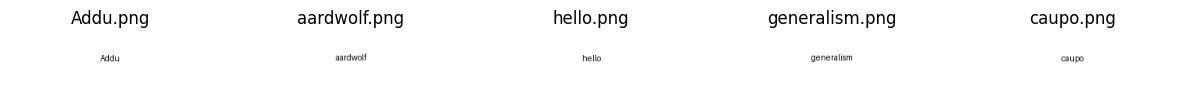

In [7]:
import matplotlib.pyplot as plt
import os
from PIL import Image

# Function to display sample images
def display_samples(output_dir, num_samples=5):
    # Get a list of all image files in the directory
    image_files = [f for f in os.listdir(output_dir) if f.endswith('.png')]
    
    # Select a few samples to display
    sample_files = image_files[:num_samples]
    
    # Plot the images
    plt.figure(figsize=(15, 5))
    for i, file in enumerate(sample_files):
        img_path = os.path.join(output_dir, file)
        img = Image.open(img_path)
        
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(file)  # Display the filename as the title
    
    plt.show()

# Call the function to display 5 samples
display_samples(output_dir, num_samples=5)


In [8]:
char_to_index = {char: idx+1 for idx, char in enumerate("abcdefghijklmnopqrstuvwxyz")}
# Add blank token for CTC loss, if necessary
char_to_index["blank"] = 0

def encode_word(word):
    word = word.lower()  # Normalize to lowercase
    return [char_to_index[char] for char in word if char in char_to_index]


In [9]:
print(encode_word('pop'))

[16, 15, 16]


In [10]:
# Define the image transformations (e.g., resize, normalization)
transform = transforms.Compose([
    transforms.Resize((64, 256)),   # Resize image to 64x256 as required
    transforms.ToTensor(),          # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Optional normalization
])

In [11]:
class WordImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        # Get all image file paths
        self.image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('.png')]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load the image
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        
        # Apply transformations if any
        if self.transform:
            image = self.transform(image)
        
        # Extract the word label (assumes the filename is the word)
        label = os.path.basename(img_path).split('.')[0]  # The word is the file name (without extension)
        label_encoded = encode_word(label)
        label_length = len(label_encoded)
        
        return image, label_encoded, label_length


In [12]:
# Path where images are stored
image_dir = 'word_images_'  # e.g., 'images/'

# Create the full dataset
dataset = WordImageDataset(image_dir=image_dir, transform=transform)

In [13]:
# Split the dataset into train (80%), validation (10%), and test (10%)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


In [14]:
from torch.nn.utils.rnn import pad_sequence

def custom_collate_fn(batch):
    images, labels, label_lengths = zip(*batch)  # Unpack the batch into three parts

    # Stack images into a single tensor
    images = torch.stack(images)

    # Convert labels to tensors and pad them
    labels = [torch.tensor(label) for label in labels]
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=0)

    # Convert label lengths to a tensor
    label_lengths = torch.tensor(label_lengths)

    return images, labels_padded, label_lengths


In [15]:
# Create DataLoaders for each dataset split
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)

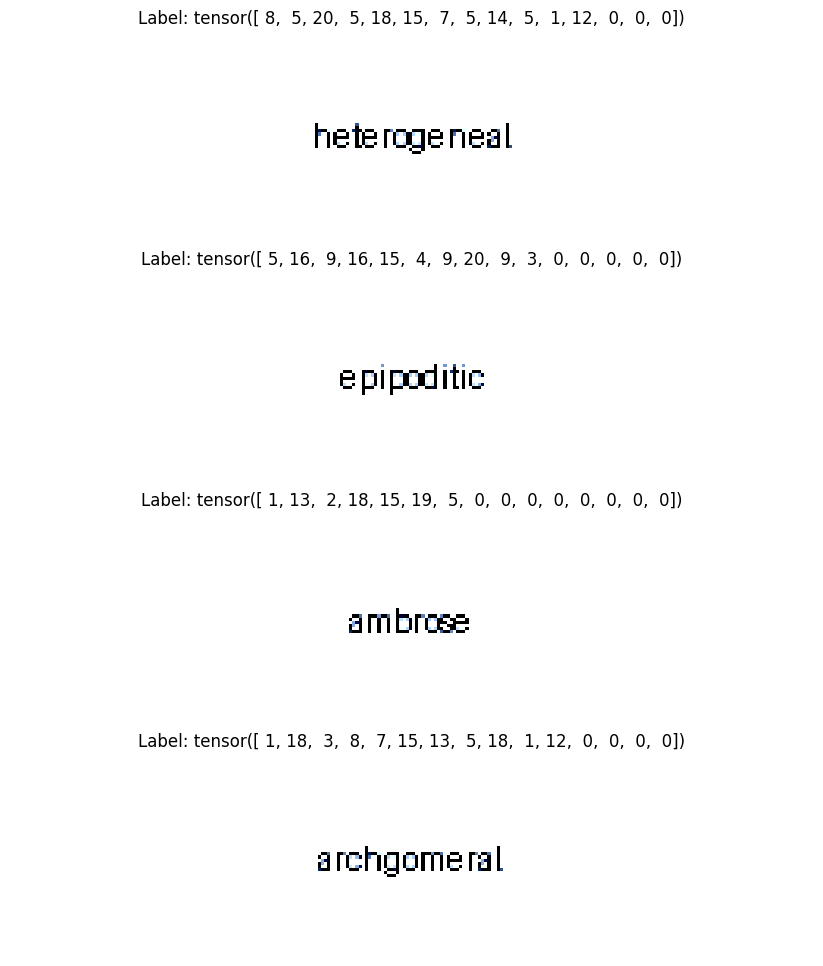

In [16]:
import matplotlib.pyplot as plt

# Get one batch of data
images, labels, label_lengths = next(iter(train_loader))
plt.figure(figsize=(12, 12)) 
# Visualize the first few images
for i in range(4):  # Display the first 4 images
    plt.subplot(4, 1, i + 1)
    plt.imshow(images[i].permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    plt.title(f"Label: {labels[i]}")
    plt.axis("off")

plt.show()


In [17]:
import torch.nn.functional as F

# Sample CNN-RNN model
class CNNEncoder(nn.Module):
    def __init__(self):
        super(CNNEncoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        # print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.shape)
        # return x.permute(0, 2, 3, 1)  # Batch x Width x Height x Channels
        return x
class RNNDecoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RNNDecoder, self).__init__()
        self.rnn = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Bidirectional

    def forward(self, features):

        seq_len = features.size(2) * features.size(3)  # Assuming height x width gives the sequence length
        # print("Features shape before reshape:", features.shape)

        features = features.reshape(features.size(0), seq_len, -1)  # Flatten height and width dimensions
        # print("Features shape after reshape:", features.shape)
        
        output, _ = self.rnn(features)
        # print(output.shape)
        output = self.fc(output)
        # print(output.shape)
        return output  # Character probabilities

class OCRModel(nn.Module):
    def __init__(self, cnn_encoder, rnn_decoder):
        super(OCRModel, self).__init__()
        self.encoder = cnn_encoder
        self.decoder = rnn_decoder

    def forward(self, x):
        features = self.encoder(x)
        output = self.decoder(features)
        return output

In [18]:
# Initialize the model, loss function, and optimizer
cnn_encoder = CNNEncoder()
rnn_decoder = RNNDecoder(input_dim=128, hidden_dim=256, output_dim=37)  # Example with 37 possible characters
model = OCRModel(cnn_encoder, rnn_decoder)

# CTC Loss
criterion = nn.CTCLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [32]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        total_train_loss = 0
        batch_train_losses = []  # To store loss per batch in training

        for batch_idx, (images, labels, label_lengths) in enumerate(train_loader):  # Assuming dataloader provides batches of images and labels
            optimizer.zero_grad()

            # Get the model outputs (shape: batch_size x max_seq_len x num_classes)
            outputs = model(images)  # (N, T, C) where N is batch size, T is time steps, C is num classes
            outputs = outputs.permute(1, 0, 2)  # (T, N, C) for CTCLoss (time x batch x classes)

            # Compute the lengths of the input sequences (i.e., the number of time steps)
            input_lengths = torch.full(size=(images.size(0),), fill_value=outputs.size(0), dtype=torch.long)

            # Flatten the labels and create target_lengths (length of each label sequence)
            flattened_labels = torch.cat([label for label in labels])  # Concatenate the label tensors
            target_lengths = torch.tensor([len(label) for label in labels], dtype=torch.long)

            # Compute the CTC loss
            loss = criterion(outputs, flattened_labels, input_lengths, target_lengths)
            
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()  # Accumulate the loss for monitoring
            batch_train_losses.append(loss.item())  # Store loss per batch

        # Print the average training loss for the entire epoch
        avg_train_loss = abs(total_train_loss) / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Average Train Loss: {avg_train_loss:.4f}")

        # Now calculate the validation loss
        model.eval()  # Set model to evaluation mode
        total_val_loss = 0
        batch_val_losses = []  # To store loss per batch in validation
        with torch.no_grad():  # Disable gradients during validation
            for batch_idx, (images, labels, label_lengths) in enumerate(val_loader):  # Assuming val_loader is available
                # Get the model outputs (shape: batch_size x max_seq_len x num_classes)
                outputs = model(images)  # (N, T, C) where N is batch size, T is time steps, C is num classes
                outputs = outputs.permute(1, 0, 2)  # (T, N, C) for CTCLoss (time x batch x classes)

                # Compute the lengths of the input sequences (i.e., the number of time steps)
                input_lengths = torch.full(size=(images.size(0),), fill_value=outputs.size(0), dtype=torch.long)

                # Flatten the labels and create target_lengths (length of each label sequence)
                flattened_labels = torch.cat([label for label in labels])  # Concatenate the label tensors
                target_lengths = torch.tensor([len(label) for label in labels], dtype=torch.long)

                # Compute the CTC loss
                loss = criterion(outputs, flattened_labels, input_lengths, target_lengths)
                total_val_loss += loss.item()  # Accumulate the validation loss
                batch_val_losses.append(loss.item())  # Store loss per batch

        # Print the average validation loss for the entire epoch
        avg_val_loss = abs(total_val_loss) / len(val_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Average Validation Loss: {avg_val_loss:.4f}")


In [31]:
import random

def evaluate(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_correct = 0
    total_samples = 0
    all_predictions = []  # To store all predictions
    all_labels = []  # To store all ground truth labels
    
    with torch.no_grad():  # Disable gradient computation for evaluation
        for images, labels, label_lengths in test_loader:

            # Get the model outputs (shape: batch_size x max_seq_len x num_classes)
            outputs = model(images)
            outputs = outputs.permute(1, 0, 2)  # (T, N, C) for CTCLoss (time x batch x classes)
            
            # Get predicted sequences (choose the character with the highest probability at each time step)
            _, predicted_indices = outputs.max(dim=2)  # Get the indices of the max values along the class dimension
            
            # Decode the predictions (convert indices to characters)
            predicted_labels = [decode_sequence(indices) for indices in predicted_indices.cpu().numpy()]
            
            # Append the predictions and true labels to the lists
            all_predictions.extend(predicted_labels)
            all_labels.extend(labels)  # Assuming labels are in a format compatible with decoding

            # Calculate the Average Number of Correct Characters for this batch
            batch_correct = 0
            for pred, target in zip(predicted_labels, labels):
                # Only compare up to the length of the target label (some labels may be shorter than others)
                batch_correct += sum(p == t for p, t in zip(pred, target))
                
            total_correct += batch_correct
            total_samples += sum(len(label) for label in labels)  # Sum the lengths of the target labels

    # Calculate the average correct characters across all samples
    average_correct_chars = total_correct / total_samples
    print(f"Average Number of Correct Characters (ANCC): {average_correct_chars:.4f}")




In [29]:
# Define your model, optimizer, and loss criterion
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CTCLoss()

# Call the train function with your data loaders
train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)


Epoch [1/10], Average Train Loss: 25.7310
Epoch [1/10], Average Validation Loss: 24.5117
Epoch [2/10], Average Train Loss: 20.5848
Epoch [2/10], Average Validation Loss: 22.0605
Epoch [3/10], Average Train Loss: 16.4678
Epoch [3/10], Average Validation Loss: 19.8545
Epoch [4/10], Average Train Loss: 13.1743
Epoch [4/10], Average Validation Loss: 17.8690
Epoch [5/10], Average Train Loss: 10.5394
Epoch [5/10], Average Validation Loss: 16.0821
Epoch [6/10], Average Train Loss: 8.4315
Epoch [6/10], Average Validation Loss: 14.4739
Epoch [7/10], Average Train Loss: 6.7452
Epoch [7/10], Average Validation Loss: 13.0265
Epoch [8/10], Average Train Loss: 5.3962
Epoch [8/10], Average Validation Loss: 11.7239
Epoch [9/10], Average Train Loss: 4.3169
Epoch [9/10], Average Validation Loss: 10.5515
Epoch [10/10], Average Train Loss: 3.4536
Epoch [10/10], Average Validation Loss: 9.4963


In [33]:
# Random Baseline Comparison
def random_baseline(test_loader):
    random_correct = 0
    total_samples = 0
    for images, labels, label_lengths in test_loader:
        # Generate random sequences of the same length as the target labels
        random_predictions = []
        for label in labels:
            random_seq = [random.choice("abcdefghijklmnopqrstuvwxyz") for _ in range(len(label))]
            random_predictions.append(random_seq)
        
        # Compare random predictions with true labels
        batch_correct = 0
        for pred, target in zip(random_predictions, labels):
            batch_correct += sum(p == t for p, t in zip(pred, target))

        random_correct += batch_correct
        total_samples += sum(len(label) for label in labels)

    # Calculate the random baseline ANCC
    baseline_correct_chars = random_correct / total_samples
    print(f"Random Baseline Average Correct Characters: {baseline_correct_chars:.4f}")



In [34]:
# Function to decode predicted indices into characters
def decode_sequence(indices):
    # Assuming you have a character set (e.g., a list or dictionary of characters)
    characters = "abcdefghijklmnopqrstuvwxyz"  # This should match your model's output space
    return ''.join([characters[idx] for idx in indices if idx != 0])  # Ignore padding (0)

In [36]:
# Evaluate the model
evaluate(model, test_loader, criterion)

# Compare with the random baseline
random_baseline(test_loader)

Average Number of Correct Characters (ANCC): 0.6142
Random Baseline Average Correct Characters: 0.0278


In [58]:
import matplotlib.pyplot as plt
# import matplotlib.pyplot as plt
# plt.rcParams['font.family'] = 'DejaVu Sans'

def plot_predictions(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    
    with torch.no_grad():  # Disable gradient computation for evaluation
        for images, labels, label_lengths in test_loader:

            # Get the model outputs (shape: batch_size x max_seq_len x num_classes)
            outputs = model(images)
            outputs = outputs.permute(1, 0, 2)  # (T, N, C) for CTCLoss (time x batch x classes)
            
            # Get predicted sequences (choose the character with the highest probability at each time step)
            _, predicted_indices = outputs.max(dim=2)  # Get the indices of the max values along the class dimension
            
            # Decode the predictions (convert indices to characters)
            predicted_labels = [decode_sequence(indices) for indices in predicted_indices.cpu().numpy()]
            
            # Select two random samples from the batch to visualize
            for i in range(2):
                image = images[i].cpu().numpy().squeeze()  # Convert to numpy and remove channel dimension (if grayscale)
                true_label = labels[i].cpu().numpy()  # Ground truth label
                predicted_label = predicted_labels[i]  # Predicted label
                # If your image is in the shape (3, 64, 256), transpose it to (64, 256, 3)
                image = image.transpose(1, 2, 0)
                
                plt.imshow(image)
                plt.title(f"Prediction: {predicted_label}")
                plt.axis('off')
                plt.show()
            
            break  # We only want to plot from the first batch, so break after the first batch

  

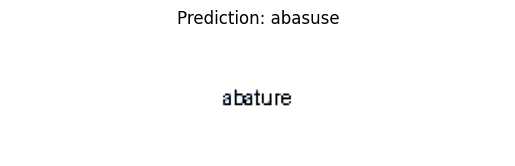

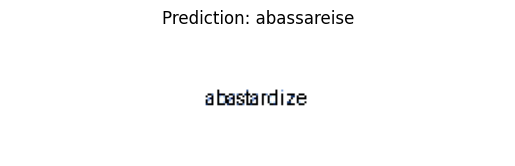

In [78]:
plot_predictions(model, test_loader)